# Docking workflow
This is a quick guide to setting up a simple linear workflow for docking small molecules.

## Imports
We will first import generally useful stuff - *maize* uses `pathlib` whenever file system paths are involved:

In [1]:
from pathlib import Path

The core functionality of *maize* is contained in the `Workflow` class.

In [2]:
from maize.core.workflow import Workflow

We will also need some steps that allow us to load and save any kind of data:

In [3]:
from maize.steps.io import LoadData, LogResult, Return, Void

Domain-specific steps are contained in the *maize-contrib* namespace package. We will need a docking step (`AutoDockGPU`) and a step to generate small molecule isomers / conformers (`Gypsum`).

In [4]:
from maize.steps.mai.docking.adv import AutoDockGPU
from maize.steps.mai.molecule import Gypsum
from maize.utilities.chem import IsomerCollection

## Preparation
### Configuration
Most available workflow nodes in Maize require some system-specific configuration, such as the location of external software packages, names of modules, or python packages. This configuration takes place in a TOML file, by default Maize looks in `$XDG_CONFIG_HOME/maize.toml` (`~/.config/maize.toml`) for a file like this:

In [5]:
!cat docking-example-config.toml


[autodockgpu]
python = "/projects/mai/users/${USER}_thomas/opt/miniconda3/envs/maize-dev/bin/python"
modules = ["CUDA", "GCC"]
commands.autodock_gpu = "/projects/mai/users/${USER}_thomas/src/AutoDock-GPU/bin/autodock_gpu_64wi" 

[gypsum]
scripts.gypsum.interpreter = "/projects/mai/users/${USER}_thomas/opt/miniconda3/envs/gypsum/bin/python"
scripts.gypsum.location = "/projects/mai/users/${USER}_thomas/src/gypsum_dl/run_gypsum_dl.py"


Here, we have configured the `AutoDockGPU` node by specifying the python interpreter to be used for its execution, the modules that need to be loaded before, as well as the precise location of the `autodock_gpu` command. We also need this information for `Gypsum` (to embed molecules), but since it's a script, we provide the script location and interpreter to use separately.

How to provide this documentation is described in the documentation for each node. They will often have a `required_callables` class attribute specifying the name of the callable to be provided in the configuration. In the above example, `AutoDockGPU` requires a callable named `autodock_gpu`, the path to which we can provide using `commands.autodock_gpu`. In other cases the executable might already be in your `$PATH` (or loaded through the module system), in which case no additional configuration is required.

### Grid
We also need to specify the target grid file. `AutoDockGPU` requires an `.fld` file with references to a few other files to operate correctly.

In [6]:
grid = Path("../maize/steps/mai/docking/data/1stp/1stp_protein.maps.fld")

## Workflow definition
We can now create our workflow instance, give it a name, and possibly specify a logging level. `cleanup_temp=False` allows us to keep all files related to the execution instead of just using temporary directories. We also load our custom configuration because it's in a non-standard location.

In [7]:
flow = Workflow(name="dock", level="info", cleanup_temp=False)
flow.config.update(Path("docking-example-config.toml"))

### Adding nodes
Workflow nodes can be added using the `add` method. We will need a node to load data and inject it into the workflow (`LoadData`), the molecule preparation and docking steps (`Gypsum` and `AutoDockGPU`), and steps to handle the output (`Void` and `Return`).

Note that steps that accept any kind of generic data should be parameterised with the type. This is the case for `LoadData`, in this case we will be passing it a list of SMILES codes (`list[str]`), and also for `Return`. Doing this allows for all connections to be type-checked statically, catching many workflow construction errors.

In [8]:
load = flow.add(LoadData[list[str]])
embe = flow.add(Gypsum)
dock = flow.add(AutoDockGPU)
void = flow.add(Void)
retu = flow.add(Return[list[IsomerCollection]])

## Configuration
We can now set the required parameters. `LoadData` requires setting the `data` parameter with the data we want to send on to the next node. We also specify that we want a maximum of 2 variants for the isomer generation / embedding step, and we also need to specify the docking grid:

In [9]:
load.data.set(["Nc1ccc(ccc1N)C", "Nc1ccc(cc1N)C"])
embe.n_variants.set(2)
dock.grid_file.set(grid)

### Connections
All that is left to do now is to connect all nodes together:

In [10]:
flow.connect(load.out, embe.inp)
flow.connect(embe.out, dock.inp)
flow.connect(dock.out, retu.inp)
flow.connect(dock.out_scores, void.inp)

We can check if everything is ready to run using the `check()` method. It will ensure all nodes in the graph are connected properly (with correct types) and also go through each node's software requirements, making sure it's all available:

In [11]:
flow.check()

If you installed *maize* with `graphviz` you can visualize the workflow in your notebook:

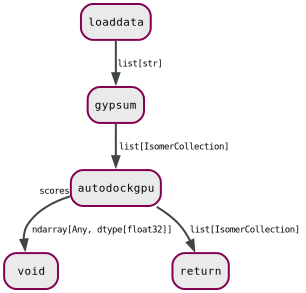

In [12]:
flow.visualize()

## Running
We can now run our graph!

In [13]:
flow.execute()

2023-09-05 10:46:50,129 |     INFO |             dock | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2023-09-05 10:46:50,130 |     INFO |             dock | Starting Maize version 0.4.1 (c) AstraZeneca 2023
2023-09-05 10:4

## Results
If all went well you should see a summary of the workflow run in the log above. `LogResult` recorded the docking scores and printed them to the log, but we also have access to the docked conformations through the `Return` node. To access this data, just call `get()`:

In [14]:
mols = retu.get()
mols

[IsomerCollection('CC1CC[C@H]([NH3+])[C@@H]([NH3+])CC1', n_isomers=2),
 IsomerCollection('Cc1ccc(N)c(N)c1', n_isomers=1, best_score=-4.43)]

Here, `IsomerCollection` is a simple container around `Isomer` objects, which in turn are pythonic wrappers around RDKit molecules. These can be accessed using the `_molecule` attribute:

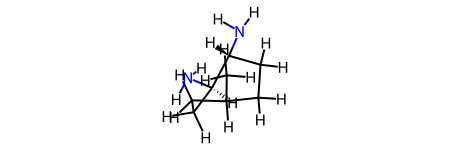

In [15]:
mols[0].molecules[0]._molecule

# Adding a custom node

In the above workflow, we just discarded the docking scores of the molecules and instead used only the docked conformations. Lets create our own node that will log the docked scores. We will first import some required classes to allow us to define our node:

In [16]:
import numpy as np
from numpy.typing import NDArray

from maize.core.interface import Input
from maize.core.node import Node

## Defining nodes

We define our custom node by creating a new class inheriting from the node class. Every workflow node must have at least one port (`Input` and / or `Output`) and a `run` method describing the logic. Ports must also declare the correct type, to minimize errors in graph construction.

In this node, we just receive the scores (a blocking call) and then print them out using the built-in logger.

In [17]:
class ScoreLog(Node):
    """Logs scores in the form of NDArrays"""

    inp: Input[NDArray[np.float32]] = Input()

    def run(self) -> None:
        scores = self.inp.receive()
        self.logger.info("Received scores: %s", scores)

## Workflow

We can now build up our workflow as normal, substituting our `ScoreLog` node for the `Void` node:

In [18]:
flow = Workflow(name="dock", level="info", cleanup_temp=False)
flow.config.update(Path("docking-example-config.toml"))

In [19]:
load = flow.add(LoadData[list[str]])
embe = flow.add(Gypsum)
dock = flow.add(AutoDockGPU)
save = flow.add(ScoreLog)
retu = flow.add(Return[list[IsomerCollection]])

Our new node has no parameters, so everything stays the same here:

In [20]:
load.data.set(["Nc1ccc(ccc1N)C", "Nc1ccc(cc1N)C"])
embe.n_variants.set(2)
dock.grid_file.set(grid)

We again connect everything together:

In [21]:
flow.connect(load.out, embe.inp)
flow.connect(embe.out, dock.inp)
flow.connect(dock.out, retu.inp)
flow.connect(dock.out_scores, save.inp)

And check we didn't make a mistake:

In [22]:
flow.check()

## Running

Let's run the new workflow, we should see the scores getting logged by our own node:

In [23]:
flow.execute()

2023-09-05 10:46:55,671 |     INFO |             dock | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2023-09-05 10:46:55,673 |     INFO |             dock | Starting Maize version 0.4.1 (c) AstraZeneca 2023
2023-09-05 10:4

# High-throughput docking
The workflow above is a classic example of a directed acyclic graph (DAG). Each step is effectively run sequentially, which is not a problem for a small number of molecules, but can become a problem for very large amounts, as we might spend a lot of time embedding molecules, while we could already start docking some of them.

In Maize we can sidestep this problem by batching our data and sending it through the same workflow repeatedly. To do this we will need two generic helper nodes, `Batch` and `Combine`:

In [24]:
import numpy as np
from numpy.typing import NDArray

from maize.steps.plumbing import Batch, Combine
from maize.steps.io import Void

## Workflow
We can now again build our workflow, we will start just like before:

In [25]:
flow = Workflow(name="dock-ht", level="info", cleanup_temp=False)
flow.config.update(Path("docking-example-config.toml"))

We again add all required nodes just like before, as well as the `Batch` and `Combine` nodes. The former will receive a list of items and split it into smaller lists, while the latter will perform the opposite. This will allow us to send smaller batches of SMILES to be docked, allowing molecules to be embedded on the CPU while the previous batch is already docking on the GPU. To make this possible, both `Gypsum` and `AutoDockGPU` will need to be able to continuously accept data, we can set this option with `loop=True`. We will finally simplify things a bit and just send the docked molecule conformations to a `Void` node, discarding them (equivalent to `/dev/null`) and only keeping the scores.

In [26]:
load = flow.add(LoadData[list[str]])
batch = flow.add(Batch[str])
embe = flow.add(Gypsum, loop=True)
dock = flow.add(AutoDockGPU, loop=True)
comb = flow.add(Combine[NDArray[np.float32]])
save = flow.add(LogResult)
void = flow.add(Void)

### Configuration
We again configure our workflow as before:

In [27]:
load.data.set(["Nc1ccc(ccc1N)C", "Nc1ccc(cc1N)C", "Nc1cc(F)c(cc1N)C", "Nc1ccc(cc1N)C(F)"])
embe.n_variants.set(2)
dock.grid_file.set(grid)

However, we now also need to set the number of batches to use, and we need to set the same value for both `Batch` and `Combine`. Instead of setting both individually we can combine both parameters into a single one to make the setting less error-prone using `combine_parameters`:

In [28]:
n_batches = flow.combine_parameters(batch.n_batches, comb.n_batches)
n_batches.set(2)

We again connect everything, but this time take a shortcut by using `connect_all`:

In [29]:
flow.connect_all(
    (load.out, batch.inp),
    (batch.out, embe.inp),
    (embe.out, dock.inp),
    (dock.out, void.inp),
    (dock.out_scores, comb.inp),
    (comb.out, save.inp),
)

We check everything's okay and look at the graph structure:

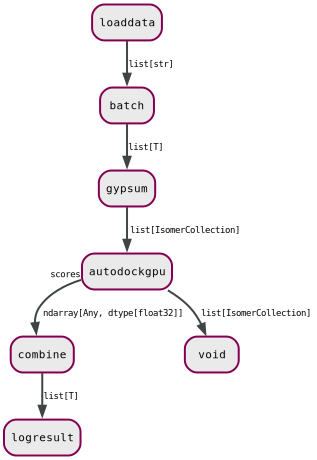

In [30]:
flow.check()
flow.visualize()

### Run
Let's run it!

In [31]:
flow.execute()

2023-09-05 10:47:01,146 |     INFO |          dock-ht | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2023-09-05 10:47:01,148 |     INFO |          dock-ht | Starting Maize version 0.4.1 (c) AstraZeneca 2023
2023-09-05 10:4

# Parallel docking
While the above example allowed us to increase our throughput, we can go even further by explicitly parallelizing our workflow. In this case, we will want to run multiple docking runs in parallel, e.g. through a job submission system such as SLURM or just on a machine with multiple GPUs.

We will use the `parallel` macro as a shortcut for this purpose, it will allow us to run a node in parallel and distribute data across it.

In [32]:
from maize.utilities.macros import parallel

## Workflow
We again setup our workflow as normal:

In [33]:
flow = Workflow(name="dock-parallel", level="info", cleanup_temp=False)
flow.config.update(Path("docking-example-config.toml"))

We can now add our nodes just as in the first example, but we now use the magical `parallel` function to convert our single `AutoDockGPU` node into a *subgraph* containing multiple copies of it. Data will be distributed using a `RoundRobin` node, i.e., one item will be sent to each output at a time, cycling through all available outputs. Outputs will be connected accordingly with a `Merge` node. If more than one output or input is present, multiple `RoundRobin` or `Merge` nodes will be used. Finally, we also need to set `loop=True` here to make sure the `AutoDockGPU` node can accept multiple rounds of inputs.

In [34]:
load = flow.add(LoadData[list[str]])
embe = flow.add(Gypsum, loop=True)
dock = flow.add(parallel(AutoDockGPU, n_branches=2, inputs=("inp",), outputs=("out", "out_scores"), loop=True))
save = flow.add(LogResult)
void = flow.add(Void)

### Configuration
Configuration is done just like before, the embedded molecules will then be distributed over both `AutoDockGPU` nodes.

In [35]:
load.data.set(["Nc1ccc(ccc1N)C", "Nc1ccc(cc1N)C", "Nc1cc(F)c(cc1N)C", "Nc1ccc(cc1N)C(F)"])
embe.n_variants.set(2)
dock.grid_file.set(grid)

We can again connect everything as normal, the internal connections for distribution and merging are taken care of by the `parallel` macro above.

In [36]:
flow.connect_all(
    (load.out, embe.inp),
    (embe.out, dock.inp),
    (dock.out, void.inp),
    (dock.out_scores, save.inp),
)

Let's check we're good to go, and also visualize what is going on inside `parallel`!

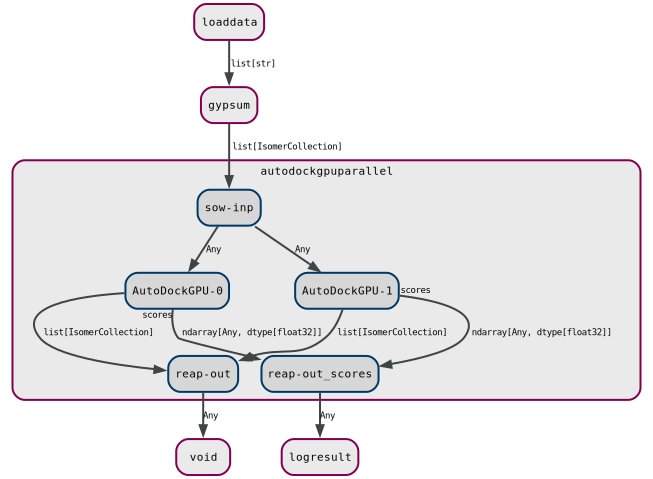

In [37]:
flow.check()
flow.visualize()

Let's go! Because my system only has a single GPU we won't actually see any speed up though (execution is blocked if required resources are not available).

In [38]:
flow.execute()

2023-09-05 10:47:08,824 |     INFO |    dock-parallel | 
              ___           ___                       ___           ___
             /\__\         /\  \          ___        /\  \         /\  \
            /::|  |       /::\  \        /\  \       \:\  \       /::\  \
           /:|:|  |      /:/\:\  \       \:\  \       \:\  \     /:/\:\  \
          /:/|:|__|__   /::\~\:\  \      /::\__\       \:\  \   /::\~\:\  \
         /:/ |::::\__\ /:/\:\ \:\__\  __/:/\/__/ _______\:\__\ /:/\:\ \:\__\
         \/__/~~/:/  / \/__\:\/:/  / /\/:/  /    \::::::::/__/ \:\~\:\ \/__/
               /:/  /       \::/  /  \::/__/      \:\~~\~~      \:\ \:\__\
              /:/  /        /:/  /    \:\__\       \:\  \        \:\ \/__/
             /:/  /        /:/  /      \/__/        \:\__\        \:\__\
             \/__/         \/__/                     \/__/         \/__/


2023-09-05 10:47:08,826 |     INFO |    dock-parallel | Starting Maize version 0.4.1 (c) AstraZeneca 2023
2023-09-05 10:4